In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import warnings
import pickle
import sys
import json
import neptune

warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')
# import modules
import visualize
import geometry_utils
import dataloader_geo
from maritime_traffic_network import MaritimeTrafficNetwork
import prediction_model_evaluation_metrics as metrics

In [2]:
# path to directory of model
location = 'tromso'
path_format = 'node2node'
directory = '../../models/gretel_prediction_models/'+location+'_small/'+path_format+'/'
# load metadata from file
with open(directory+'/metadata.json', 'r') as json_file:
    meta_dict = json.load(json_file)
meta_dict

{'network_name': '202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM',
 'n_points': 796177,
 'n_nodes': 541,
 'n_edges': 2139,
 'training_dates': "['202204', '202205']",
 'data_version': '',
 'n_training_paths': 2927,
 'node_features': "['n_members']",
 'egde_features': "['direction', 'length', 'weight']",
 'path_format': 'node2node',
 'lr': 0.001,
 'loss': 'target_only',
 'n_epochs': 20,
 'target_prediction': 'next',
 'n_walks': 200,
 'n_start_nodes': 1,
 'n_steps': 2,
 'prediction_task': 'path',
 'model_type': 'Gretel',
 'test_dates': "['202206']",
 'selection_start': 0,
 'selection_end': -1,
 'selection_step': 2,
 'n_test_paths': 761}

In [3]:
# set parameters for prediction
prediction_task = meta_dict['prediction_task']
eval_mode = 'path'
n_start_nodes= meta_dict['n_start_nodes']
n_steps = meta_dict['n_steps']
network_name = meta_dict['network_name']
test_dates = literal_eval(meta_dict['test_dates'])

In [4]:
# load maritime traffic network
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [5]:
# Load test trajectories from file
traj_path_prefix = '../../data/processed/'
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

In [6]:
# load predictions from file
predictions = pd.read_csv(directory+'predictions.csv')
predictions['ground_truth'] = predictions['ground_truth'].apply(literal_eval)
predictions['prediction'] = predictions['prediction'].apply(literal_eval)

In [7]:
# check if all predictions are valid
for index, row in predictions.iterrows():
    if geometry_utils.is_valid_path(network.G, row['ground_truth']) == False:
        print(row['mmsi'].tolist())

Evaluating 761 samples for path prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.52 minutes


Percentage of unsuccessful predictions: 0.13%
Mean SSPD: 398.32m
Median SSPD: 167.33m
Mean choice_accuracy: 0.6336


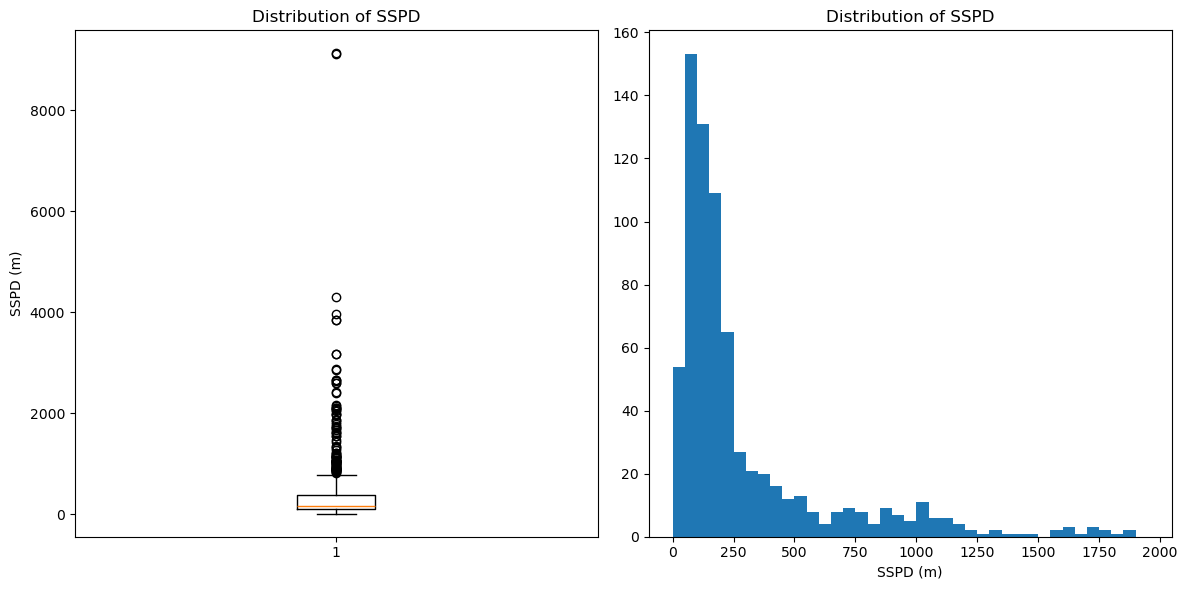

In [8]:
# evaluate
#evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
#                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, eval_mode=eval_mode)

https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-121
Evaluating 761 samples for path prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.51 minutes


Percentage of unsuccessful predictions: 0.13%
Mean SSPD: 398.32m
Median SSPD: 167.33m
Mean choice_accuracy: 0.6336


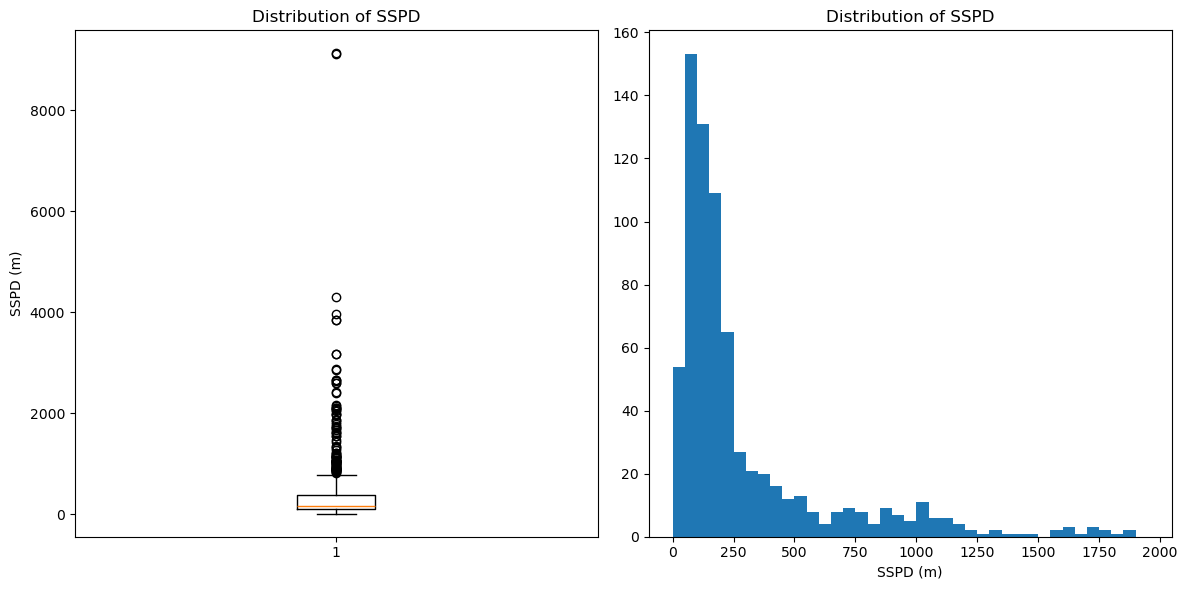

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 41 operations to synchronize with Neptune. Do not kill this process.
All 41 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-121/metadata


In [9]:
run = neptune.init_run(
    project="jandrik91/RoutePredictions",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
)  # your credentials

# evaluate
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, 
                                                             eval_mode=eval_mode)

nan_mask = evaluation_results.isna().any(axis=1)
failure_rate = nan_mask.sum() / len(evaluation_results)
mean_abs_err = np.mean(evaluation_results[~nan_mask]["SSPD"])
median_abs_err = np.median(evaluation_results[~nan_mask]["SSPD"])
choice_accuracy = np.mean(evaluation_results[~nan_mask]["choice_accuracy"])

# save experiment
run["network_name"] = network_name
run["n_points"]=len(network.gdf)
run["n_nodes"]=network.G.number_of_nodes()
run["n_edges"]=network.G.number_of_edges()

params = network.hyperparameters
params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
run["network_parameters"] = params

run["training_data"] = {'training_dates':meta_dict['training_dates'],
                        'n_training_paths':meta_dict['n_training_paths']}

run["test_data"] = {'test_dates':str(test_dates),
                    'selection_start':meta_dict['selection_start'],
                    'selection_end':meta_dict['selection_end'],
                    'selection_step':meta_dict['selection_step'],
                    'n_test_paths':meta_dict['n_test_paths']}

run["prediction_task"] = prediction_task
run["eval_mode"] = eval_mode
run["model_type"] = meta_dict['model_type']
run["n_start_nodes"] = n_start_nodes
run["n_steps"] = n_steps

run['node_features'] = meta_dict['node_features']
run['egde_features'] = meta_dict['egde_features']
run['path_format'] = meta_dict['path_format']
run['lr'] = meta_dict['lr']
run['loss'] = meta_dict['loss']
run['n_epochs'] = meta_dict['n_epochs']
run['MOGen_n_walks'] = meta_dict['n_walks']
run['target_prediction'] = meta_dict['target_prediction']

run["plot"].upload(fig)
run["failure_rate"] = failure_rate
run["mean_abs_err"] = mean_abs_err
run["median_abs_err"] = median_abs_err
run["choice_accuracy"] = choice_accuracy

run.stop()


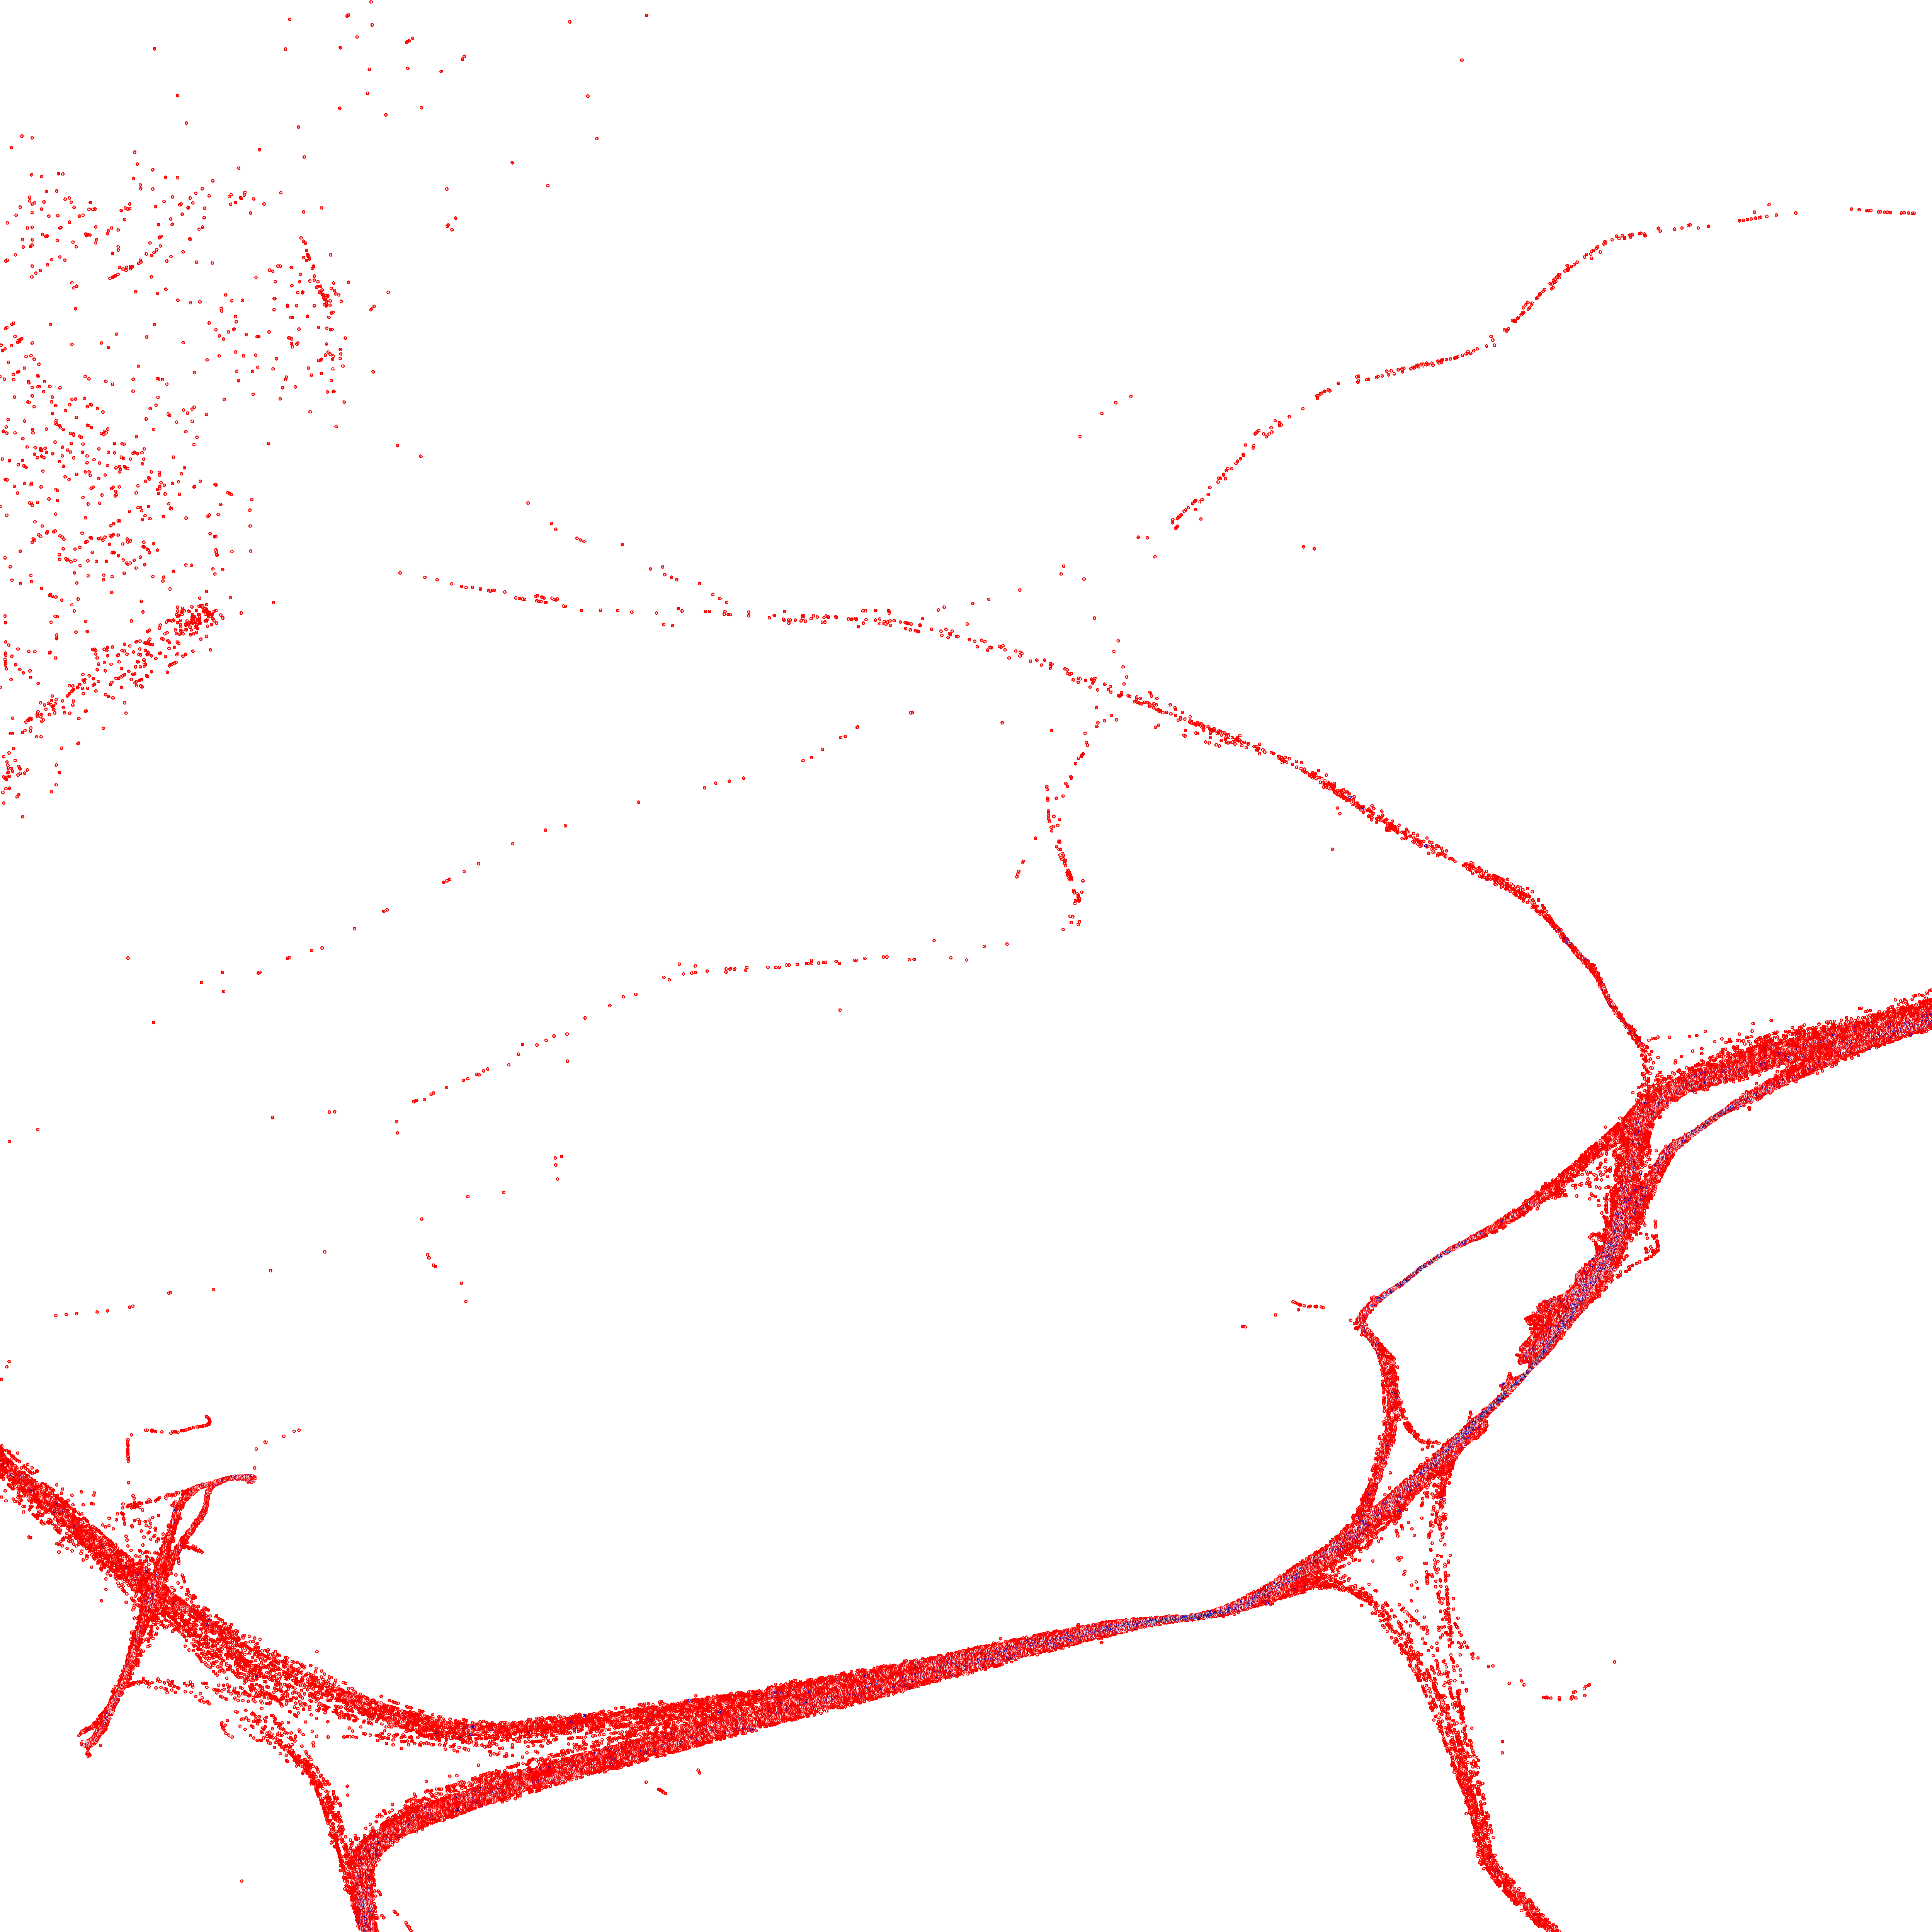

In [10]:
i = 0
mmsi = evaluation_results['mmsi'].iloc[i]
predictions = {evaluation_results['predicted_path'].iloc[i] : 1}
start_node = [evaluation_results['predicted_path'].iloc[i][0]]
trajectory = test_trajectories.get_trajectory(mmsi)
true_path = evaluation_results['true_path'].iloc[i]
map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location='tromso')
map

In [11]:
true_path

(130,
 129,
 128,
 4,
 350,
 349,
 323,
 309,
 455,
 459,
 482,
 481,
 499,
 501,
 500,
 519,
 523,
 522,
 524,
 533,
 532,
 531,
 530,
 526,
 525,
 516,
 494,
 452,
 454,
 453,
 443,
 431,
 168,
 109,
 5,
 300,
 306,
 307,
 304,
 305,
 2,
 269,
 268,
 267,
 270,
 273,
 272,
 266,
 265,
 264,
 263,
 364,
 468,
 469,
 474,
 473,
 470,
 464,
 472,
 382)